In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='final_dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('final_dataset.zip')
f.keys()
!unzip final_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: final_dataset/train/3_right_turn/right turn2037.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2039.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2040.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2041.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2048.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2049.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2050.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2053.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2054.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2060.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2062.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2063.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2065.jpg  
  inflating: final_dataset/train/3_right_turn/right turn2066.jpg  
  inflating

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.12.0


In [ ]:
train_dir = '/content/final_dataset/train'
validation_dir = '/content/final_dataset/val'
test_dir = '/content/final_dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
no_classes = 13

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6259 files belonging to 13 classes.
Found 1687 files belonging to 13 classes.
Found 839 files belonging to 13 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
        tf.keras.layers.RandomBrightness(factor=0.2)
    ],
    name="img_augmentation",
)

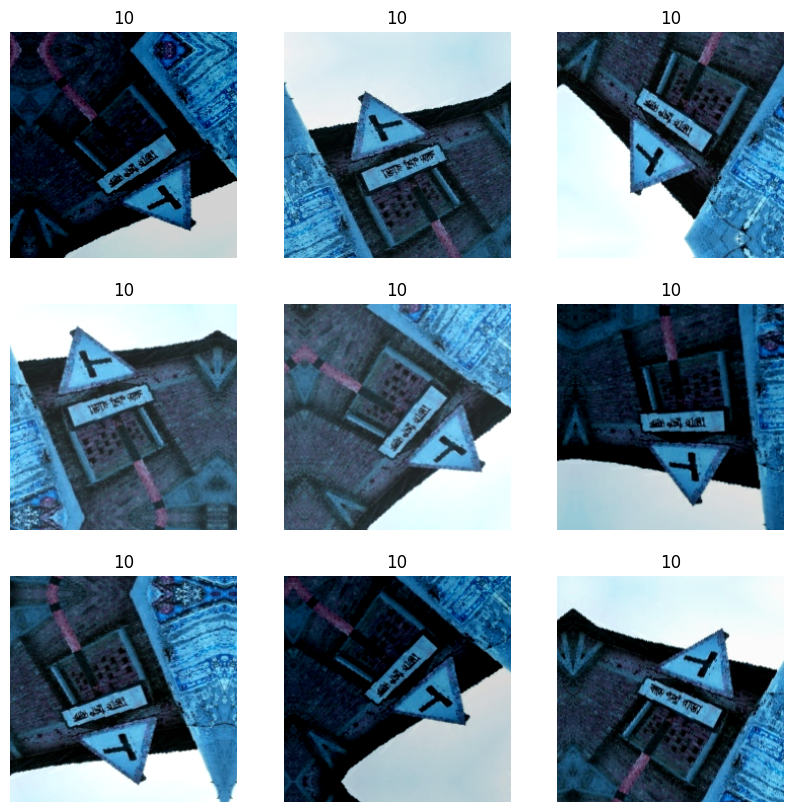

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.DenseNet201(
    weights="imagenet",  # Load weights pre-trained on ImageNet. knowladge share
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
nb_classes = 13
inputs = keras.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)
outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0     

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 30
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/30
196/196 [==============================] - 85s 305ms/step - loss: 1.6278 - accuracy: 0.4943 - val_loss: 1.2457 - val_accuracy: 0.6538
Epoch 2/30
196/196 [==============================] - 41s 209ms/step - loss: 0.8667 - accuracy: 0.7611 - val_loss: 0.9078 - val_accuracy: 0.7694
Epoch 3/30
196/196 [==============================] - 41s 208ms/step - loss: 0.6710 - accuracy: 0.8180 - val_loss: 0.7345 - val_accuracy: 0.8079
Epoch 4/30
196/196 [==============================] - 41s 208ms/step - loss: 0.5628 - accuracy: 0.8382 - val_loss: 0.6682 - val_accuracy: 0.8115
Epoch 5/30
196/196 [==============================] - 43s 220ms/step - loss: 0.5192 - accuracy: 0.8503 - val_loss: 0.5813 - val_accuracy: 0.8328
Epoch 6/30
196/196 [==============================] - 43s 219ms/step - loss: 0.4572 - accuracy: 0.8671 - val_loss: 0.5641 - val_accuracy: 0.8382
Epoch 7/30
196/196 [==============================] - 41s 209ms/step - loss: 0.4347 - accuracy: 0.8743 - val_loss: 0.5409 - val_ac

In [ ]:
scores = model.evaluate(test_dataset)

27/27 [==============================] - 6s 234ms/step - loss: 0.2914 - accuracy: 0.9142


In [ ]:
class_names = test_dataset.class_names
class_names

['0_left turn',
 '10_mosque_infront',
 '11_side_road_right',
 '12_school_infront',
 '1_crossroad',
 '2_market_infront',
 '3_right_turn',
 '4_pedestrian_crossing',
 '5_rail_crossing',
 '6_speed_breaker',
 '7_side_road_left',
 '8_college_infront',
 '9_speed_limit']

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 39ms/step


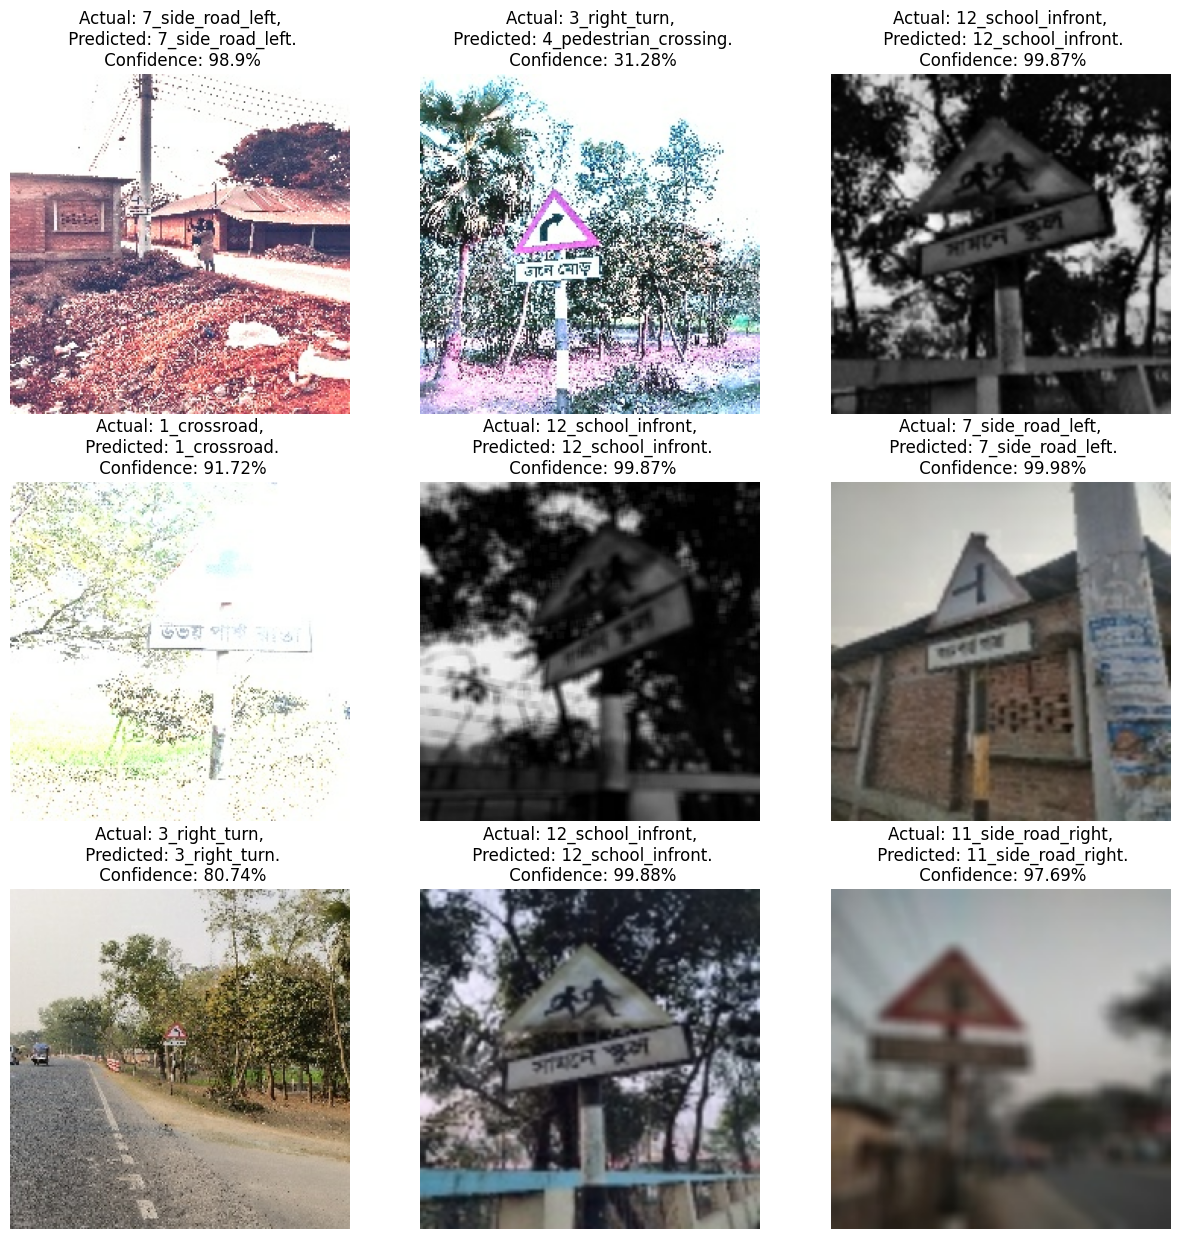

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='test.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('test.zip')
f.keys()
!unzip test.zip

Archive:  test.zip
   creating: test/
  inflating: test/IMG20230228181526.jpg  
  inflating: test/IMG20230228181936.jpg  
  inflating: test/IMG20230228181937.jpg  
  inflating: test/IMG_20230228_153940.jpg  
  inflating: test/IMG_20230228_154105 (2).jpg  
  inflating: test/IMG_20230228_154121 (2).jpg  
  inflating: test/IMG_20230228_154132.jpg  
  inflating: test/IMG_20230228_154413.jpg  
  inflating: test/IMG_20230228_154501.jpg  
  inflating: test/IMG_20230228_154502.jpg  
  inflating: test/IMG_20230228_155100.jpg  
  inflating: test/IMG_20230228_155102.jpg  
  inflating: test/IMG_20230228_155113.jpg  
  inflating: test/IMG_20230228_155545.jpg  
  inflating: test/IMG_20230228_155547.jpg  
  inflating: test/IMG_20230228_155640.jpg  
  inflating: test/IMG_20230228_155710.jpg  
  inflating: test/IMG_20230228_155716.jpg  
  inflating: test/IMG_20230228_160628.jpg  
  inflating: test/IMG_20230228_161901.jpg  
  inflating: test/IMG_20230228_162133.jpg  
  inflating: test/IMG_20230228_16221

In [ ]:
image_to_predict = [
    "/content/test/IMG20230228181526.jpg", 
    "/content/test/IMG20230228181936.jpg",
    "/content/test/IMG20230228181937.jpg",
    "/content/test/IMG_20230228_153940.jpg",
   "/content/test/IMG_20230228_154105 (2).jpg",
    "/content/test/IMG_20230228_154121 (2).jpg",
    "/content/test/IMG_20230228_154132.jpg",
    "/content/test/IMG_20230228_154413.jpg",
    "/content/test/IMG_20230228_154501.jpg",
    "/content/test/IMG_20230228_154502.jpg",
    "/content/test/IMG_20230228_155113.jpg",
    "/content/test/IMG_20230228_155545.jpg",
    "/content/test/IMG_20230228_155547.jpg",
    "/content/test/IMG_20230228_155640.jpg",
    "/content/test/IMG_20230228_155710.jpg",
    "/content/test/IMG_20230228_155716.jpg",
    "/content/test/IMG_20230228_160628.jpg",
    "/content/test/IMG_20230228_161901.jpg",
    "/content/test/IMG_20230228_162133.jpg",
    "/content/test/IMG_20230228_162218.jpg",
    "/content/test/IMG_20230228_162229 (2).jpg",
    "/content/test/IMG_20230228_162333.jpg",
    "/content/test/IMG_20230228_163326.jpg",
    "/content/test/IMG_20230228_163406.jpg",
    "/content/test/IMG_20230228_163739.jpg",
    "/content/test/IMG_20230228_163741.jpg",
    "/content/test/IMG_20230228_163827 (2).jpg",
    "/content/test/IMG_20230228_175945.jpg",
    "/content/test/IMG_20230228_180036.jpg",
    "/content/test/IMG_20230228_180050 (2).jpg",
    "/content/test/IMG_20230228_181559.jpg",
    "/content/test/IMG_20230228_181807.jpg",
    "/content/test/IMG_20230228_182024.jpg",
    "/content/test/IMG_20230228_182147.jpg",
    "/content/test/IMG_20230228_182211.jpg",
    "/content/test/IMG_20230228_182239.jpg",
    "/content/test/IMG_20230228_182339.jpg",
    "/content/test/IMG_20230228_182340.jpg",
    "/content/test/IMG_20230228_155100.jpg",
    "/content/test/IMG_20230228_155102.jpg"

  

    ]
for imgi in image_to_predict:
  img = keras.utils.load_img(imgi, target_size=(224,224))
  ix = keras.utils.img_to_array(img)
  ix = np.expand_dims(ix, axis=0)
  prediction = model.predict(ix)
  cls = tf.argmax(prediction[0], axis=-1)
  print(prediction, cls)
  print(f'{class_names[cls]} --> {imgi}')

1/1 [==============================] - 0s 36ms/step
[[1.2183089e-02 9.7797567e-01 9.3217139e-05 4.3444466e-06 7.9017438e-05
  1.4634373e-03 6.1835404e-03 2.4056305e-04 2.1101661e-04 5.2742733e-05
  4.1350012e-04 1.0998324e-03 3.8255671e-08]] tf.Tensor(1, shape=(), dtype=int64)
10_mosque_infront --> /content/test/IMG20230228181526.jpg
1/1 [==============================] - 0s 35ms/step
[[3.1518048e-04 5.6547270e-04 9.4047666e-01 4.1336571e-07 1.1007813e-03
  2.9824235e-02 3.6462376e-04 2.0886061e-03 1.8307934e-02 1.7923190e-03
  4.9038078e-03 2.5978434e-04 1.0890648e-07]] tf.Tensor(2, shape=(), dtype=int64)
11_side_road_right --> /content/test/IMG20230228181936.jpg
1/1 [==============================] - 0s 60ms/step
[[1.1076403e-03 6.9374481e-04 7.2690767e-01 2.1763721e-07 7.1544515e-04
  6.6138707e-02 1.0288969e-03 2.1502568e-04 2.5765706e-02 1.7490853e-01
  1.4591517e-03 1.0590579e-03 1.6610420e-07]] tf.Tensor(2, shape=(), dtype=int64)
11_side_road_right --> /content/test/IMG202302281

In [ ]:
'''
IMG_20230228_153940 = crossroad (+1)
IMG_20230228_154501 = crossroad (+1)
IMG_20230228_154502 = crossroad (+1)

IMG_20230228_154105 (2) = market in front (+1)
IMG_20230228_154121 (2)= market in front (+1)
IMG_20230228_154132 = market in front (+1)

IMG_20230228_154413 = Left turn (-1) (crossroad)
IMG_20230228_155545 = Left turn (-1) (pedestriain crossing)
IMG_20230228_155547 = Left turn (-1) (pedestriain crossing)
IMG_20230228_160628 = Left turn (+1)

IMG_20230228_155100 = Right turn (+1)
IMG_20230228_155102 = Right turn (+1)
IMG_20230228_155113  = Right turn (+1)

IMG_20230228_155640 = Pedestrian crossing (+1)
IMG_20230228_155710 = Pedestrian crossing (+1)
IMG_20230228_155716 = Pedestrian crossing (+1)

IMG_20230228_161901 = Speed breaker (+1)
IMG_20230228_162218 =  Speed breaker (+1)
IMG_20230228_162229 (2) =  Speed breaker (+1)

IMG_20230228_163326  = Rail crossing (+1)
IMG_20230228_163406 = Rail crossing (+1)
IMG_20230228_162133 = Rail crossing (+1)

IMG_20230228_163739 = college in front (+1)
IMG_20230228_163741 = college in front (+1)
IMG_20230228_163827 (2) = college in front (+1)

IMG_20230228_175945 = speed limit (+1)
IMG_20230228_180036 = speed limit (+1)
IMG_20230228_180050 (2) = speed limit (+1)

IMG_20230228_181559 = Mosque in front (+1)
IMG_20230228_181807 = Mosque in front (+1)
IMG20230228181526 = Mosque in front (+1)

IMG_20230228_182147 = school in front (+1)
IMG_20230228_182211 = school in front (+1)
IMG_20230228_182239 = school in front (+1)

IMG_20230228_182339 = Side road leftt (+1)
IMG_20230228_182340 = = Side road leftt (+1)
IMG_20230228_162333 = Side road left (+1)

IMG_20230228_182024 = Side road right (+1)
IMG20230228181936 = Side road right (+1)
IMG20230228181937 = Side road right (+1)

hit = ? miss = ?
acc = ?
'''

'\nIMG_20230228_153940 = crossroad (+1)\nIMG_20230228_154501 = crossroad (+1)\nIMG_20230228_154502 = crossroad (+1)\n\nIMG_20230228_154105 (2) = market in front (+1)\nIMG_20230228_154121 (2)= market in front (+1)\nIMG_20230228_154132 = market in front (+1)\n\nIMG_20230228_154413 = curve to the left (+1)\nIMG_20230228_155545 = curve to the left (-1) predict(curve to the right)\nIMG_20230228_155547 = curve to the left (+1)\nIMG_20230228_160628 = curve to the left (+1)\n\nIMG_20230228_155100 = curve to the right (-1) predict(curve to the left)\nIMG_20230228_155102 = curve to the right (+1)\nIMG_20230228_155113  = curve to the right (+1)\n\nIMG_20230228_155640 = crossing (+1)\nIMG_20230228_155710 = crossing (+1)\nIMG_20230228_155716 = crossing (+1)\n\nIMG_20230228_161901 = speed bump (+1)\nIMG_20230228_162218 =  speed bump (+1)\nIMG_20230228_162229 (2) =  speed bump (+1)\n\nIMG_20230228_163326  = railroad crossing (+1)\nIMG_20230228_163406 = railroad crossing (+1)\nIMG_20230228_162133 = ra